# Midterm 1

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

* Name: Jose Luna 
* Disclaimer: I used my own code and also utilized GPT for syntax and editing corrections.

# Instructions

## Please note the following:

Points
* The exam is `100` points.
* You have `125` minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.


Submission
* You will upload your solution to the `Midterm 1` assignment on Canvas, where you downloaded this. (Be sure to **submit** on Canvas, not just **save** on Canvas.
* Your submission should be readable, (the graders can understand your answers,)
* and it should **include all code used in your analysis in a file format that the code can be executed.** 

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo--you are welcome to use the code posted there without citation.

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

This exam makes use of the following data files:
* `midterm_1_data.xlsx`

This file has sheets for...
* `stocks excess returns` - excess returns of the 14 biggest companies in the S&P.
* `proshares excess returns` - excess returns of ETFs and indexes from the Proshares case study.
* `fx carry excess returns` - excess returns from FX products.

Note the data is **monthly** for the first two sheets (stocks and proshares). Any annualizations for those two sheets should use `12` months in a year. Annualization for the third sheet (fx carry excess returns) is explained in section 4.

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 15     |
| 2       | 25     |
| 3       | 35     |
| 4       | 25     |

### Each numbered question is worth 5 points unless otherwise specified.

***

# 1. Short Answer

#### No Data Needed

These problems do not require any data file. Rather, analyze them conceptually. 

### 1.

#### (10pts)

In the mean-variance optimization of `homework 1`, suppose we found the mean excess return of TIPS is 4% annualized.

Explain--conceptually--how each of the following would have impacted the new (with TIPS) MV solution.
* TIPS is found to have correlation of 0% to `IEF` and 0% to SPY.
* TIPS is found to have correlation of 100% to `IEF`.

Would it be possible for TIPS to have been found to have 0% correlation to every other asset in `homework 1`? Explain.

*Answer*:

* If `TIPS` is found to have a correlation of 0% with `IEF` and `SPY`, and a mean excess return of 4% annualized (almost four times the real annualized return of `TIPS` and `IEF`), it would expand the efficient frontier due to the diversification component (0% correlation) and substantial mean return. In HW1, we observed that including or excluding `TIPS` did not significantly affect the tangency portfolio, but a slight change (one standard deviation) impacted the mean and variance of the portfolio (the Sharpe Ratio remained mostly the same). With these characteristics, `TIPS` should have a significant impact on the Efficient Frontier and, consequently, on the Tangency Portfolio.

* Conversely, if `TIPS` is found to have a 4% annualized return and a correlation of 100% with `IEF`, the justification for including `TIPS` as a new asset class would be valid. This is because the asset's performance would be better, and the correlation with others should be as low as `IEF`, allowing for better performance and an inflation-linked result.

It is unlikely for `TIPS` to have a 0% correlation with all assets because `TIPS` has a similar default risk to domestic bonds, making it almost impossible to have no correlation with all other assets.

### 2. 

Depending on the application, one may or may not choose to include an intercept term in a linear factor decomposition of an asset’s returns. In what circumstances would I prefer to include an intercept, and in what circumstances would I not?

*Answer*:

When deciding whether to include an intercept term (α) in a linear factor decomposition for hedging, it is important to consider the role of the intercept. Including an intercept allows the β coefficient to focus on matching the return variation rather than just the level. If the intercept is excluded, the β coefficient will also adjust the magnitude of the returns. Therefore, if we expect the difference in mean returns to persist out-of-sample, we should not include the intercept term (α). This ensures that the β coefficient accurately reflects the relationship.

***

# 2. Portfolio Allocation

For this question you will only use data from the sheet `stocks excess returns`.

It contains excess returns for the 14 largest stocks in the S&P.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew,kurtosis,norm
import statsmodels.api as sm

filename = '../data/midterm_1_data.xlsx'
# filename = r"C:\Users\josel\Downloads\multi_asset_etf_data (1).xlsx"
stocks_excess_returns = pd.read_excel(filename,sheet_name="stocks excess returns",index_col="date")
proshares_excess_returns = pd.read_excel(filename,sheet_name="proshares excess returns",index_col="date")
fx_carry_returns = pd.read_excel(filename,sheet_name="fx carry returns",index_col="date")

### 1.

Calculate the tangency portfolio from the start of the sample to December of 2018 (to 2018-12-31), which we call in-sample period. Use the following methods:
- Traditional tangency portfolio.
- Regularized tangency portfolio (divide by 2 every element outside of the diagonal in the covariance matrix prior to the calculation).

Return:
- The weights of each asset for the traditional tangency portfolio and the regularized tangency portfolio.
- The sum of absolute values of the weights for the traditional tangency portfolio and the regularized tangency portfolio:

$$
\sum_{i=1}^{n} |w_i|
$$


In [3]:
def weights_tang(return_db, adj_factor = 12):
    sigma = (return_db.cov()*adj_factor)
    mu_excess = (return_db.mean()*adj_factor)
    vector = np.ones(len(mu_excess))
    w_tan = (np.linalg.inv(sigma) @ mu_excess )/(np.transpose(vector) @ np.linalg.inv(sigma) @ mu_excess)
    weights_db = pd.DataFrame({"w_tan": w_tan})
    weights_db.index = return_db.columns
    return weights_db

def weights_tag_reg(return_db, adj_factor = 12, diagonal_factor = 1, denominator = 2):
    sigma = (return_db.cov()*adj_factor)
    sigma_reg = (sigma + diagonal_factor*np.diag(np.diag(sigma)))/denominator
    mu_excess = (return_db.mean()*adj_factor)
    vector = np.ones(len(mu_excess))
    w_tan = (np.linalg.inv(sigma_reg) @ mu_excess )/(np.transpose(vector) @ np.linalg.inv(sigma_reg) @ mu_excess)
    weights_db = pd.DataFrame({"w_tan_reg": w_tan})
    weights_db.index = return_db.columns
    return weights_db

def get_metrics(port_metrics,weights = [],adj_factor = 12):
    if len(weights) == 0:
        port_metrics_r = pd.DataFrame({"Mean": port_metrics.mean()*adj_factor,"Volatility":port_metrics.std()*np.sqrt(adj_factor)})
        port_metrics_r["Sharpe_Ratio"] = (port_metrics.mean() / port_metrics.std()) * np.sqrt(adj_factor)
        port_metrics_r["Skew"] = skew(port_metrics)
        port_metrics_r["Excess Kurtosis"] = kurtosis(port_metrics, fisher=True, bias=False)    
    else:
        port_metrics = port_metrics @ weights
        port_metrics_r = pd.DataFrame({"Mean": port_metrics.mean()*adj_factor,"Volatility":port_metrics.std()*np.sqrt(adj_factor)})
        port_metrics_r["Sharpe_Ratio"] = (port_metrics.mean() / port_metrics.std()) * np.sqrt(adj_factor)
        port_metrics_r["Skew"] = skew(port_metrics)
        port_metrics_r["Excess Kurtosis"] = kurtosis(port_metrics, fisher=True, bias=False)
    return port_metrics_r

def VaR_CVaR_Drawdown_metrics(data_daily_return):
    result = pd.DataFrame()
    for asset in data_daily_return.columns:

        data_aux = data_daily_return[[asset]].copy()

            
        VaR = np.percentile(sorted(data_aux.values),q = 5)
        CVaR = data_aux[data_aux[asset] <= VaR].mean().values[0]

        data_aux_acum_return = (data_aux + 1).cumprod()
        data_aux_max_cum_return = data_aux_acum_return.cummax()
        data_aux_drawdown = ((data_aux_acum_return-data_aux_max_cum_return)/data_aux_max_cum_return)
        max_drawdown = data_aux_drawdown.min().values[0]
        max_drawdown_date = data_aux_drawdown.idxmin().values[0]
        peak_idx = data_aux_max_cum_return.idxmax().values[0]

        recovery_idx = data_aux_drawdown[data_aux_drawdown.idxmin().values[0]:].gt(-0.00001).idxmax().values[0]

        aux_result = pd.DataFrame([[VaR,CVaR,max_drawdown,max_drawdown_date,peak_idx,recovery_idx,(recovery_idx - max_drawdown_date)/ np.timedelta64(1, 'D')]], columns= ["VaR","CVaR","Max Drawdown","Bottom","Peak","Recovery","Duration (days)"], index = [asset])
        result = pd.concat([result,aux_result],axis=0)

    return result,data_aux_drawdown

def get_metrics_all(returns,adj_factor = 12):
    metrics1 = get_metrics(returns,adj_factor = 12)
    metrics2,_ = VaR_CVaR_Drawdown_metrics(returns)
    return pd.merge(metrics1,metrics2, left_index= True, right_index=True, how = "left")

In [4]:
in_sampple_end = "2018-12-31"
stocks_excess_returns_in_sample = stocks_excess_returns[stocks_excess_returns.index <= in_sampple_end].copy()
w_tang = weights_tang(stocks_excess_returns_in_sample, adj_factor = 12)
w_tang_reg = weights_tag_reg(stocks_excess_returns_in_sample, adj_factor = 12, diagonal_factor = 1, denominator = 2)
weights = pd.merge(w_tang, w_tang_reg, left_index=True, right_index=True)

In [5]:
print("Weights of each assets for tangency portfolio and regularized tangency portfolio: ") 
display(weights.style.format("{:.2%}"))

Weights of each assets for tangency portfolio and regularized tangency portfolio: 


,w_tan,w_tan_reg
AAPL,-12.78%,-1.47%
AMZN,-4.06%,3.63%
BRK-B,13.13%,10.92%
GOOGL,2.60%,5.05%
JNJ,13.04%,9.92%
JPM,-1.39%,5.37%
LLY,35.27%,21.49%
META,3.05%,3.49%
MSFT,13.79%,9.00%
NVDA,16.35%,7.17%


In [6]:
print("Sum of the absolutes weightes of the tangency portfolio and regularized tangency portfolio: ") 
np.abs(weights).sum()

Sum of the absolutes weightes of the tangency portfolio and regularized tangency portfolio: 


w_tan        2.197687
w_tan_reg    1.342647
dtype: float64

### 2.

Calculate the annualized summary statistics (mean, Sharpe, vol) of both portfolios in-sample.


In [6]:
print("In-sample metrics: ") 

display(get_metrics(stocks_excess_returns_in_sample @ weights,adj_factor = 12)[["Mean","Volatility","Sharpe_Ratio"]].style.format("{:.2%}"))

In-sample metrics: 


,Mean,Volatility,Sharpe_Ratio
w_tan,34.83%,13.41%,259.79%
w_tan_reg,27.66%,11.42%,242.24%


### 3.

Use the weights calculated in question (2.2) to produce portfolio returns out-of-sample for both the Traditional and Regularized portfolio (from January 2019 onwards). 

Report the **last 3 returns** of both portfolios in the out-of-sample (the traditional tangency portfolio and the regularized tangency portfolio).

In [7]:
stocks_excess_returns_out_of_sample = stocks_excess_returns[stocks_excess_returns.index > in_sampple_end].copy()
out_of_sample_portfolios_returns = stocks_excess_returns_out_of_sample @ weights
print("Out-of-sample last 3 returns for Tangency portfolio and regularized Tangency: ")
display(out_of_sample_portfolios_returns.tail(3).style.format("{:.2%}"))

Out-of-sample last 3 returns for Tangency portfolio and regularized Tangency: 


,w_tan,w_tan_reg
date,,
2024-07-31 00:00:00,-1.60%,0.32%
2024-08-31 00:00:00,10.12%,6.46%
2024-09-30 00:00:00,-2.52%,-1.65%


### 4.

Report the annualized summary statistics (Mean, Vol and Sharpe) of both portfolios in the out-of-sample.

Note: you are using the weights optimized for the in-sample and generating statistics with the out-of-sample returns.

In [8]:
print("Out-of-sample metrics: ")
display(get_metrics(out_of_sample_portfolios_returns,adj_factor = 12)[["Mean","Volatility","Sharpe_Ratio"]].style.format("{:.2%}"))

Out-of-sample metrics: 


,Mean,Volatility,Sharpe_Ratio
w_tan,32.16%,22.24%,144.62%
w_tan_reg,26.87%,17.63%,152.37%


### 5.
Which portfolio has better adjusted by risk returns in the out-of-sample? Could there be a mathematical/optimization reason why one portfolio had better adjusted by risk performance? 

Relate your answer to your findings in question (2.2) (Sum of absolute weights in the traditional and regularized tangency portfolio.)

*Answer*:

* The traditional Tangency Portfolio, in the sample, showed a sum of the absolute weights of the assets of approximately 220%, which indicates an "extreme" result. This is probably because the covariance matrix is nearly singular (i.e., the determinant is close to zero), making the optimal result unstable and leading to extreme weights and a large net exposure.

* On the other hand, the regularized portfolio, which reduces the covariance between the assets by half, does not have this numerical problem with the covariance matrix. As a consequence, the absolute values of the weights are less than those of the traditional Tangency Portfolio (134% vs. 220%).

In terms of out-of-sample performance, the Tangency Regularized Portfolio showed better performance in terms of excess return adjusted by volatility compared to the traditional Tangency Portfolio (even though the in-sample data showed the opposite). This is expected due to the regularization process.

***

# 3. Hedging and Replication

For this question you will only use data from the sheet `proshares returns`.

The following assets excess returns are available in this sheet:

- **HDG US Equity**: ProShares Hedge Replication ET
- **QAI US Equity**: NYLI Hedge Multi-Strategy Trac
- **SPY US Equity**: SPDR S&P 500 ETF Trust
- **EEM US Equity**: iShares MSCI Emerging Markets
- **EFA US Equity**: iShares MSCI EAFE ETF
- **EUO US Equity**: ProShares UltraShort Euro
- **IWM US Equity**: iShares Russell 2000 ETF
- **SPXU US Equity**: ProShares UltraPro Short S&P 5
- **UPRO US Equity**: ProShares UltraPro S&P 500

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew,kurtosis,norm
import statsmodels.api as sm

filename = '../data/midterm_1_data.xlsx'
# filename = r"C:\Users\josel\Downloads\multi_asset_etf_data (1).xlsx"
stocks_excess_returns = pd.read_excel(filename,sheet_name="stocks excess returns",index_col="date")
proshares_excess_returns = pd.read_excel(filename,sheet_name="proshares excess returns",index_col="date")
fx_carry_returns = pd.read_excel(filename,sheet_name="fx carry returns",index_col="date")

In [8]:
proshares_excess_returns.columns

Index(['HDG US Equity', 'QAI US Equity', 'SPY US Equity', 'EEM US Equity',
       'EFA US Equity', 'EUO US Equity', 'IWM US Equity', 'SPXU US Equity',
       'UPRO US Equity'],
      dtype='object')

In [9]:
def Linear_Factor_Descomposition(data, y_asset,x_asset, adj = 12, constant = True):

    Y = data[y_asset]
    X = data[x_asset]

    if constant:
        X = sm.add_constant(X)

    mod = sm.OLS(Y, X).fit()
    inter = mod.params.values[0]

    rsquare = mod.rsquared
    std_errors= mod.resid.std()
    tracking_error = mod.resid.std() * np.sqrt(adj)

    metrics = pd.DataFrame([[inter,inter*adj,rsquare,std_errors,tracking_error]],columns=["Alpha","Alpha Adj","R-square","std_errors","tracking_error"], index = [y_asset])
    return pd.DataFrame(mod.params).T, metrics,mod.summary(),mod.resid

### 1. 

You work at a hedge fund.

Suppose the hedge fund is long $1 million of HDG and wants to hedge the position.

A junior analyst suggests that we can hedge our position by looking at some select ETFs, and then taking a position in the ETFs that will offset the risk of our HDG position.

They pick QAI, SPY, EEM, UPRO, SPXU, IWM, and EFA.

What dollar position would we be taking in each ETF to hedge your HDG position?

In [37]:
def time_series_regression(data, y_asset, x_asset, adj=12, constant=True):
    Y = data[y_asset]
    X = data[x_asset]

    if constant:
        X = sm.add_constant(X)

    mod = sm.OLS(Y, X).fit()

    if constant:
        inter = mod.params.values[0]
        betas = mod.params[1:].values
    else:
        inter = np.nan
        betas = mod.params.values

    rsquare = mod.rsquared
    std_errors = mod.resid.std()
    tracking_error = mod.resid.std() * np.sqrt(adj)

    # Calculate Treynor Ratio, Information Ratio, and Tracking Error
    treynor_ratio = (adj * Y.mean()) / mod.params[0] if not constant else (adj * Y.mean()) / mod.params[1]
    info_ratio = (
        np.sqrt(adj) * inter / std_errors if std_errors != 0 and constant else np.nan
    )

    # Construct the metrics dataframe conditionally
    if constant:
        metrics_columns = [
            "Alpha", "Alpha Adj",
            *([f"{col}" for col in x_asset]),
            "R-square", "std_errors", "Tracking_error",
            "Treynor Ratio", "Information Ratio"
        ]
        metrics_values = [
            inter, inter * adj,
            *betas,
            rsquare, std_errors, tracking_error,
            treynor_ratio, info_ratio
        ]
    else:
        metrics_columns = [
            *([f"{col}" for col in x_asset]),
            "R-square", "std_errors", "Tracking_error",
            "Treynor Ratio"
        ]
        metrics_values = [
            *betas,
            rsquare, std_errors, tracking_error,
            treynor_ratio
        ]

    metrics = pd.DataFrame([metrics_values], columns=metrics_columns, index=[y_asset])
    return metrics

In [38]:
assets = ['QAI US Equity', 'SPY US Equity', 'EEM US Equity', 'UPRO US Equity', 'SPXU US Equity', 'IWM US Equity','EFA US Equity']

In [39]:
results = time_series_regression(proshares_excess_returns, "HDG US Equity", assets, adj=12)

C:\Users\josel\AppData\Local\Temp\ipykernel_35528\4217607054.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  treynor_ratio = (adj * Y.mean()) / mod.params[0] if not constant else (adj * Y.mean()) / mod.params[1]


In [40]:
(results[assets]  * -1_000_000).style.format('${:,.0f}')

,QAI US Equity,SPY US Equity,EEM US Equity,UPRO US Equity,SPXU US Equity,IWM US Equity,EFA US Equity
HDG US Equity,"$-151,537","$-515,376","$-44,816","$140,222","$-32,654","$-139,036","$-117,000"


In [13]:
beta, metrics,summary, _ = Linear_Factor_Descomposition(proshares_excess_returns, y_asset = "HDG US Equity",x_asset = assets, adj = 12,constant = True)
print("Hedge of HDG with other assets, including intercept (alpha): ")
display((beta[assets] * -1_000_000).style.format('${:,.0f}'))
print(f"Total amount invested: ${(beta[assets] * -1_000_000).sum(axis=1)[0]:,.0f}")

Hedge of HDG with other assets, including intercept (alpha): 


,QAI US Equity,SPY US Equity,EEM US Equity,UPRO US Equity,SPXU US Equity,IWM US Equity,EFA US Equity
0,"$-151,537","$-515,376","$-44,816","$140,222","$-32,654","$-139,036","$-117,000"


Total amount invested: $-860,198


In [14]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          HDG US Equity   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     228.7
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           1.13e-76
Time:                        17:03:16   Log-Likelihood:                 615.52
No. Observations:                 158   AIC:                            -1215.
Df Residuals:                     150   BIC:                            -1191.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0005      0.000     -1.100      0.273      -0.001       0.000
QAI US Equity      0.1879      0.068      2.758      0.007       0.053       0.323
SPY US Equity     -0.0490      0.047     -1.046      0.297      -0.142       0.044
EEM US Equity      0.0538      0.015      3.538      0.001       0.024       0.084
EUO US Equity      0.0340      0.013      2.710      0.008       0.009       0.059
SPXU US Equity    -0.0116      0.012     -0.933      0.352      -0.036       0.013
IWM US Equity      0.1305      0.015      8.759      0.000       0.101       0.160
EFA US Equity      0.1378      0.025      5.473      0.000       0.088       0.188
==============================================================================
Omnibus:                       28.239   Durbin-Watson:                   2.550
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.208
Skew:                          -0.627   Prob(JB):                     4.25e-20
Kurtosis:                       6.461   Cond. No.                         176.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
beta2, metrics2,summary2,_ = Linear_Factor_Descomposition(proshares_excess_returns, y_asset = "HDG US Equity",x_asset = assets, adj = 12,constant = False)
print("Hedge of HDG with other assets, without including intercept (alpha): ")
display((beta2[assets] * -1_000_000).style.format('${:,.0f}'))
print(f"Total amount invested: ${(beta2[assets] * -1_000_000).sum(axis=1)[0]:,.0f}")

Hedge of HDG with other assets, without including intercept (alpha): 


,QAI US Equity,SPY US Equity,EEM US Equity,UPRO US Equity,SPXU US Equity,IWM US Equity,EFA US Equity
0,"$-166,629","$-240,419","$-44,877","$69,393","$-16,065","$-139,894","$-120,177"


Total amount invested: $-658,669


* Notes: We observe that including the intercept in the regression does not significantly impact the other regressors, and the intercept itself is not significant (p-value = 0.273). Therefore, we could exclude it. However, for the next questions, we will consider the regression with the intercept to ensure that the regressors focus on matching the variance rather than the level.

### 2.

#### (7pts)
What is the gross notional of the hedge?

What is the R-squared of the hedge?

What do these two statistics indicate about the practical use of this hedge?

*Answer*:

1. What is the gross notional of the hedge?

In [23]:
print(f"Total amount invested: ${(beta* -1_000_000).abs().sum(axis=1)[0]:,.0f}")

Total amount invested: $1,141,653


In [41]:
results[assets+["Alpha"]].abs().sum(axis=1)* -1_000_000

HDG US Equity   -1.141653e+06
dtype: float64

2. What is the R-squared of the hedge?

In [14]:
print(f"The R-squared of the model is: {metrics['R-square'][0]:.2%}")

The R-squared of the model is: 91.29%


C:\Users\josel\AppData\Local\Temp\ipykernel_11632\716814244.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"The R-squared of the model is: {metrics['R-square'][0]:.2%}")


In [42]:
results["R-square"]

HDG US Equity    0.912884
Name: R-square, dtype: float64

3. What do these two statistics indicate about the practical use of this hedge?

*Answer*: These show that we are able to replicate the variance of HDG with this portfolio of ETF with a significant result (R-Squared of 91.43%)

### 3.

Suppose instead we don't want to hedge our position. We believe that the value of HDG can be *entirely* determined by some combination of the other ETFs. 

So, you propose the following model:

$$
HDG_t = \beta_1 QAI_t + \beta_2 SPY_t + \beta_3 EEM_t + \varepsilon_t
$$

We think any difference between the value of HDG and the value of the ETFs is a mispricing, and will revert to 0 in the future. We call such a strategy "trading the residuals".

Therefore, if $\varepsilon_t > 0$, we should be short HDG and long the basket, and if $\varepsilon_t < 0$, we should be long HDG and short the basket.

Now...
* Run the model specified above and report the $\beta$'s values.
* After, create the "basket" portfolio, using the $\beta$'s as weights (they do not need to add up to one). Report the final three values.

In [47]:
assets = ['QAI US Equity', 'SPY US Equity', 'EEM US Equity']
beta, metrics,summary, residuals = Linear_Factor_Descomposition(proshares_excess_returns, y_asset = "HDG US Equity",x_asset = assets, adj = 12,constant = False)

In [226]:
beta_repeated = pd.DataFrame( [beta.values[0]] * len(residuals), columns=beta.columns, index=residuals.index)
residuals = pd.DataFrame(residuals,columns = ["Residuals"])

In [227]:
print("Beta basket portfolio: ")
beta

Beta basket portfolio: 


,QAI US Equity,SPY US Equity,EEM US Equity
0,0.356368,0.162696,0.086523


In [228]:
print("Basket portfolio returns: ")

(proshares_excess_returns[assets] @ beta.values[0]).tail(5)

Basket portfolio returns: 


date
2024-05-31    0.014722
2024-06-30    0.009141
2024-07-31    0.006721
2024-08-31    0.007373
2024-09-30    0.013569
dtype: float64

In [48]:
results = time_series_regression(proshares_excess_returns, "HDG US Equity", assets, adj=12, constant=False)

C:\Users\josel\AppData\Local\Temp\ipykernel_35528\4217607054.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  treynor_ratio = (adj * Y.mean()) / mod.params[0] if not constant else (adj * Y.mean()) / mod.params[1]


In [49]:
results[assets]

,QAI US Equity,SPY US Equity,EEM US Equity
HDG US Equity,0.356368,0.162696,0.086523


In [50]:
proshares_excess_returns[assets] @ results[assets].values[0]

date
2011-08-31   -0.019264
2011-09-30   -0.034678
2011-10-31    0.040854
2011-11-30   -0.005206
2011-12-31   -0.001341
                ...   
2024-05-31    0.014722
2024-06-30    0.009141
2024-07-31    0.006721
2024-08-31    0.007373
2024-09-30    0.013569
Length: 158, dtype: float64

### 4.

#### (8pts)

Construct the strategy indicated by the approach in the previous problem.

For a given period $t$:
- if the $\varepsilon_t \leq 0$ (is negative or equal to 0), you should be long HDG 200% in HDG and short 100% in the basket portfolio **in period $t+1$**.
- if the $\varepsilon_t > 0$ (is positive), you should be long 200% in the basket portfolio and short 100% **in HDG in period $t+1$**.

Do not worry about the look forward bias: in this scenario, you should run the model only once with the entire dataset and define your $\varepsilon_t$ for any $t$ also considering the model that has acess to data in $t+1, t+2, ...$ to make the calculation.  

Report the annualized summary statistics of this strategy (Mean, Vol and Sharpe).

In [229]:
combined_df = pd.concat([residuals, beta_repeated], axis=1)
combined_df['HDG US Equity'] = 1

combined_df.loc[combined_df["Residuals"] <= 0,['QAI US Equity', 'SPY US Equity', 'EEM US Equity']] = combined_df.loc[combined_df["Residuals"]<= 0,['QAI US Equity', 'SPY US Equity', 'EEM US Equity']]*(-1)
combined_df.loc[combined_df["Residuals"] <= 0,['HDG US Equity']] = combined_df.loc[combined_df["Residuals"]<= 0,['HDG US Equity']]*(2)

combined_df.loc[combined_df["Residuals"] > 0,['HDG US Equity']] = combined_df.loc[combined_df["Residuals"]> 0,['HDG US Equity']]*(-1)
combined_df.loc[combined_df["Residuals"] > 0,['QAI US Equity', 'SPY US Equity', 'EEM US Equity']] = combined_df.loc[combined_df["Residuals"] > 0,['QAI US Equity', 'SPY US Equity', 'EEM US Equity']]*2

basket_portfolio = pd.DataFrame((combined_df[['HDG US Equity','QAI US Equity', 'SPY US Equity', 'EEM US Equity']].shift(1) * proshares_excess_returns[['HDG US Equity','QAI US Equity', 'SPY US Equity', 'EEM US Equity']]).sum(axis = 1), columns = ["Strategy"])

In [230]:
get_metrics(basket_portfolio,adj_factor = 12)[["Mean","Volatility","Sharpe_Ratio"]].style.format("{:.2%}")

,Mean,Volatility,Sharpe_Ratio
Strategy,3.66%,6.21%,58.92%


### 5.

On a different matter, we are now studying QAI and want to track (replicate) it using the other available ETFs.

Use an intercept and report:

- $\beta$ (and the sum of $\beta$'s absolute value).
- $\alpha$ and Information Ratio.
- $R^2$.
- Correlation matrix between the assets used to replicate QAI.

In [63]:
assets = proshares_excess_returns.drop(["QAI US Equity"],axis=1).columns.values

In [51]:
assets = ["HDG US Equity", 'SPY US Equity', 'EEM US Equity', 'EUO US Equity', 'SPXU US Equity', 'IWM US Equity','EFA US Equity']

In [190]:
beta, metrics,summary, residuals = Linear_Factor_Descomposition(proshares_excess_returns, y_asset = 'QAI US Equity',x_asset = assets, adj = 12,constant = True)

In [64]:
results = time_series_regression(proshares_excess_returns, "QAI US Equity", assets, adj=12)

C:\Users\josel\AppData\Local\Temp\ipykernel_35528\4217607054.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  treynor_ratio = (adj * Y.mean()) / mod.params[0] if not constant else (adj * Y.mean()) / mod.params[1]


In [65]:
results

,Alpha,Alpha Adj,HDG US Equity,SPY US Equity,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity,SPXU US Equity,UPRO US Equity,R-square,std_errors,Tracking_error,Treynor Ratio,Information Ratio
QAI US Equity,-0.000525,-0.006296,0.231451,0.565072,0.047792,0.032642,-0.020484,-0.000157,0.051074,-0.095099,0.841988,0.005739,0.019879,0.110836,-0.316726


In [191]:
print("Beta replication: ")
beta

Beta replication: 


,const,HDG US Equity,SPY US Equity,EEM US Equity,EUO US Equity,SPXU US Equity,IWM US Equity,EFA US Equity
0,-0.000038,0.256858,0.209397,0.045641,-0.022248,0.027051,-0.004894,0.028546


In [66]:
print("Sum Absolite Beta replication: ")
np.abs(beta).sum(axis=1)

Sum Absolite Beta replication: 


0    0.605588
dtype: float64

In [67]:
results[assets].abs().sum(axis=1)

QAI US Equity    1.043771
dtype: float64

In [193]:
print("Alpha: ")
metrics["Alpha Adj"]

Alpha: 


QAI US Equity   -0.000452
Name: Alpha Adj, dtype: float64

In [194]:
print("R-Squared: ")

metrics["R-square"].values[0]

R-Squared: 


0.840320194914061

In [195]:
proshares_excess_returns[assets].corr()

,HDG US Equity,SPY US Equity,EEM US Equity,EUO US Equity,SPXU US Equity,IWM US Equity,EFA US Equity
HDG US Equity,1.000000,0.873618,0.801281,-0.419163,-0.814764,0.894708,0.894867
SPY US Equity,0.873618,1.000000,0.708186,-0.381608,-0.955545,0.867994,0.865371
EEM US Equity,0.801281,0.708186,1.000000,-0.601403,-0.656500,0.661675,0.833854
EUO US Equity,-0.419163,-0.381608,-0.601403,1.000000,0.401212,-0.308918,-0.575282
SPXU US Equity,-0.814764,-0.955545,-0.656500,0.401212,1.000000,-0.805117,-0.812151
IWM US Equity,0.894708,0.867994,0.661675,-0.308918,-0.805117,1.000000,0.784217
EFA US Equity,0.894867,0.865371,0.833854,-0.575282,-0.812151,0.784217,1.000000


### 6.

Explain how good is your replication, pointing out at least one good or bad argument related to each of the statistics mentioned in the bullet points above (thus, you should have at least 4 arguments).

*Answer:*

* The R-squared is significant for replication, at almost 85%.
* The betas are reasonable, all less than 1 in absolute value.
* The sum of the absolute values of the betas is less than one, indicating that the replication portfolio is not costly.
* However, the correlation between the assets is high in some cases, suggesting potential multicollinearity.

Overall, the replication is reasonable based on the statistical parameters.

***

# 4. 

The data in sheet `fx carry excess returns` has **excess** daily returns for trading currencies.
* You **do NOT need** to know anything about FX, currency, or the underlying strategies.
* Rather, just take these return series as given.

For the problems below, we will **only use** the `JPY` series.

In [68]:
fx_carry_returns = pd.read_excel(filename,sheet_name="fx carry returns",index_col="date")

### 1.

Calculate the `1%` VaR as follows...

Empirical VaR:
* At every point in time, calculate the `1st` quantile of the returns up to that point.
* No need to scale the answers.
  
Report the VaR for the final date of the sample.

In [69]:
fx_carry_returns = fx_carry_returns[["JPY"]]

In [ ]:
fx_carry_returns["Hist_VaR"] = fx_carry_returns.shift().expanding(min_periods = 60).quantile(.01)["JPY"]

In [40]:
fx_carry_returns["Hist_VaR"].dropna().tail(1)

date
2024-08-05   -0.017178
Name: Hist_VaR, dtype: float64

<Axes: title={'center': 'Empirical VaR of JPY'}, xlabel='date'>

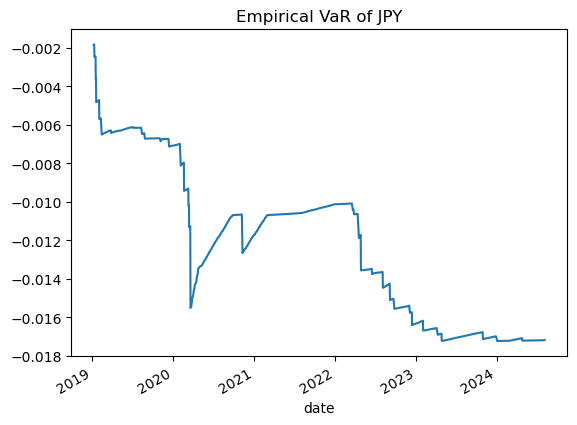

In [44]:
fx_carry_returns["Hist_VaR"].plot(title="Empirical VaR of JPY")

### 2.

Now calculate the `normal VaR` of `JPY` as follows,

$$\text{Normal VaR (1\%)} = -2.33\, \sigma_t$$

where $\sigma_t$ is estimated with
* rolling volatility.
* using a window of `233` days.
* without using a sample mean.

Report the VaR for the final `3 days` of the sample.

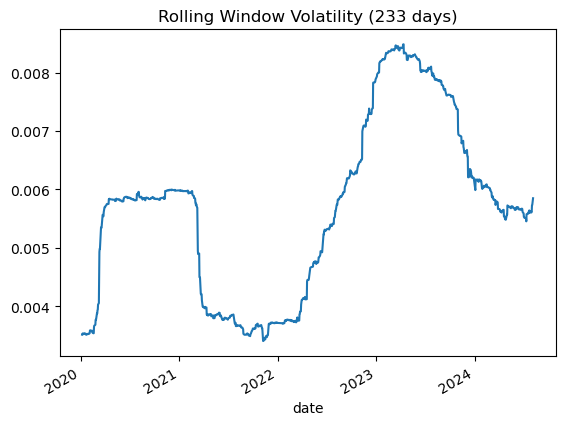

In [45]:
fx_carry_returns["Rolling_Vol"] = np.sqrt((fx_carry_returns.shift()["JPY"]**2).rolling(233).mean())
fx_carry_returns["Rolling_Vol"].plot(title="Rolling Window Volatility (233 days)")
fx_carry_returns["Normal_VaR_Rolling_Vol"] = fx_carry_returns["Rolling_Vol"]*(-2.33)

<Axes: title={'center': 'Normal VaR with Rolling Volatility'}, xlabel='date'>

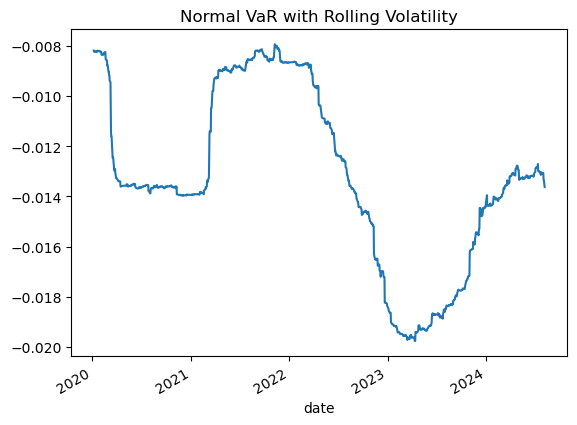

In [46]:
fx_carry_returns["Normal_VaR_Rolling_Vol"].plot(title="Normal VaR with Rolling Volatility") 

In [47]:
fx_carry_returns["Normal_VaR_Rolling_Vol"].tail(3)

date
2024-08-01   -0.013350
2024-08-02   -0.013359
2024-08-05   -0.013631
Name: Normal_VaR_Rolling_Vol, dtype: float64

### 3.

Now calculate the `normal VaR` of `JPY` as follows,

$$\text{Normal VaR (1\%)} = -2.33\, \sigma_t$$

where $\sigma_t$ is estimated with
* EWMA volatility
* using $\lambda = 0.94$.
* without using a sample mean.

Report the VaR for the final `3 days` of the sample.

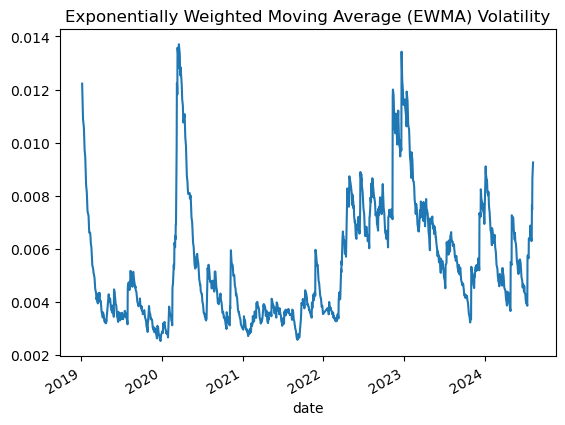

In [48]:
def ewma(returns, theta = 0.94, sigma_zero = 0.2/np.sqrt(252)):
    ewma_var = [sigma_zero**2]
    for i in range(len(returns)):
        var = ewma_var[-1]*theta + (returns.iloc[i]**2)*(1-theta)
        ewma_var.append(var)
    ewma_var = np.sqrt(ewma_var[1:])
    return ewma_var
fx_carry_returns["EWMA_Vol"] = ewma(fx_carry_returns["JPY"])
fx_carry_returns["EWMA_Vol"].plot(title="Exponentially Weighted Moving Average (EWMA) Volatility")
fx_carry_returns["Normal_VaR_EWMA_Vol"] = fx_carry_returns["EWMA_Vol"].shift()*(-2.33)

In [49]:
fx_carry_returns["Normal_VaR_EWMA_Vol"].tail(3)

date
2024-08-01   -0.017824
2024-08-02   -0.017430
2024-08-05   -0.020140
Name: Normal_VaR_EWMA_Vol, dtype: float64

### 4.

Make a plot of the three timeseries of your VaR estimates.

Succinctly point out the pros / cons of these approaches.

<Axes: xlabel='date'>

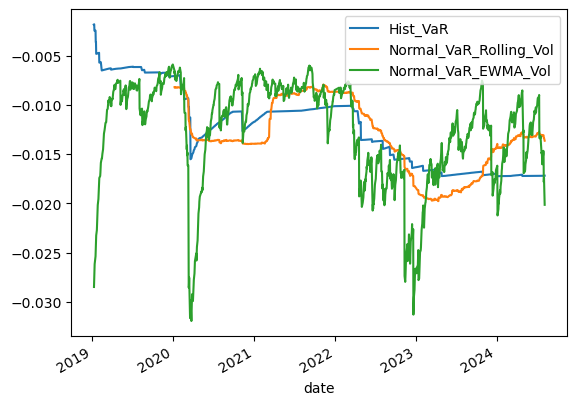

In [50]:
fx_carry_returns[['Hist_VaR',"Normal_VaR_Rolling_Vol","Normal_VaR_EWMA_Vol"]].plot()

* The Historical VaR requires a larger sample size to produce robust results. With a confidence level of q = 1%, more data is needed than in the homework exercises to avoid direct interpolation. However, the empirical method is easy to calculate and does not make any assumptions about the distribution of returns.
* In contrast, other methods (parametric) work properly with less data because they only use volatility to estimate VaR. These methods assume a normal distribution, which is not always accurate. The Rolling Volatility method loses past information, giving more weight to recent dates. The EWMA Volatility method assigns weights to both past and recent data, with a parameter of 0.94 giving more importance to the most recent data.

### 5.

What statistic do we use to judge the performance of a VaR model?

Estimate and report this statistic across the VaR methods.

Which VaR model do you find is best?

In [51]:
Hit_Ratio_Hist_VaR = fx_carry_returns.loc[fx_carry_returns["JPY"] < fx_carry_returns["Hist_VaR"],"JPY"].count()/len(fx_carry_returns["Hist_VaR"].dropna())
Hit_Ratio_Normal_VaR_Rolling_Vol = fx_carry_returns.loc[fx_carry_returns["JPY"] < fx_carry_returns["Normal_VaR_Rolling_Vol"],"JPY"].count()/len(fx_carry_returns["Normal_VaR_Rolling_Vol"].dropna())
Hit_Ratio_Normal_VaR_EWMA_Vol = fx_carry_returns.loc[fx_carry_returns["JPY"] < fx_carry_returns["Normal_VaR_EWMA_Vol"],"JPY"].count()/len(fx_carry_returns["Normal_VaR_EWMA_Vol"].dropna())


In [52]:
print("Hit Ratio of Historical VaR: ", Hit_Ratio_Hist_VaR)
print("Hit Ratio Error of Historical VaR: ", abs(Hit_Ratio_Hist_VaR/0.01 - 1))

Hit Ratio of Historical VaR:  0.022988505747126436
Hit Ratio Error of Historical VaR:  1.2988505747126435


In [53]:
print("Hit Ratio of Rolling VaR: ", Hit_Ratio_Normal_VaR_Rolling_Vol)
print("Hit Ratio Error of Rolling VaR: ", abs(Hit_Ratio_Normal_VaR_Rolling_Vol/0.01 - 1))

Hit Ratio of Rolling VaR:  0.025186567164179104
Hit Ratio Error of Rolling VaR:  1.5186567164179103


In [54]:
print("Hit Ratio of EWMA Vol VaR: ", Hit_Ratio_Normal_VaR_EWMA_Vol)
print("Hit Ratio Error of EWMA Vol VaR: ", abs(Hit_Ratio_Normal_VaR_EWMA_Vol/0.01 - 1))

Hit Ratio of EWMA Vol VaR:  0.019938650306748466
Hit Ratio Error of EWMA Vol VaR:  0.9938650306748464


We can see that the empirical VaR and the Rolling VaR underestimate the real VaR, with a Hit Ratio Error of 1.5. On the other hand, the EWMA Volatility VaR showed the best result, with a Hit Ratio Error of 0.14. Therefore, in this case, it is better to use a parametric VaR with an EWMA Volatility model.

***